## 예제 2-1. 시각화 예시

### 호주 방문자 수 데이터 시각화

#### 필요한 패키지 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing

#### 데이터 불러오기

In [2]:
austa = pd.read_csv('https://raw.githubusercontent.com/safeai-snu/Econometrics/refs/heads/main/Part.1/data/aus_visit.csv',index_col=0)
austa['Month'] = pd.to_datetime(austa['Month'])

#### 학습 데이터 분리

In [3]:
austa_up_to_2010 = austa[austa['Month'] <= '2010-12-31']

#### 모델 피팅

In [4]:
model = ExponentialSmoothing(austa_up_to_2010['Visitors'], seasonal='add', seasonal_periods=12).fit()

#### 시뮬레이션 예측

In [5]:
forecast_start_date = '2011-01-01'
forecast_steps = 48  
num_simulations = 100
prediction = model.forecast(steps=forecast_steps)

np.random.seed(1967)
simulated_paths = pd.DataFrame()
residual_std = model.resid.std()

for i in range(num_simulations):
    new_residuals = np.random.normal(0, residual_std, size=forecast_steps)
    simulated_forecast = prediction + new_residuals
    simulated_df = pd.DataFrame({
        'Month': pd.date_range(start=forecast_start_date, periods=forecast_steps, freq='M'),
        'Visitors': simulated_forecast,
        'Simulation': i + 1
    })
    simulated_paths = pd.concat([simulated_paths, simulated_df], ignore_index=True)

#### 시각화

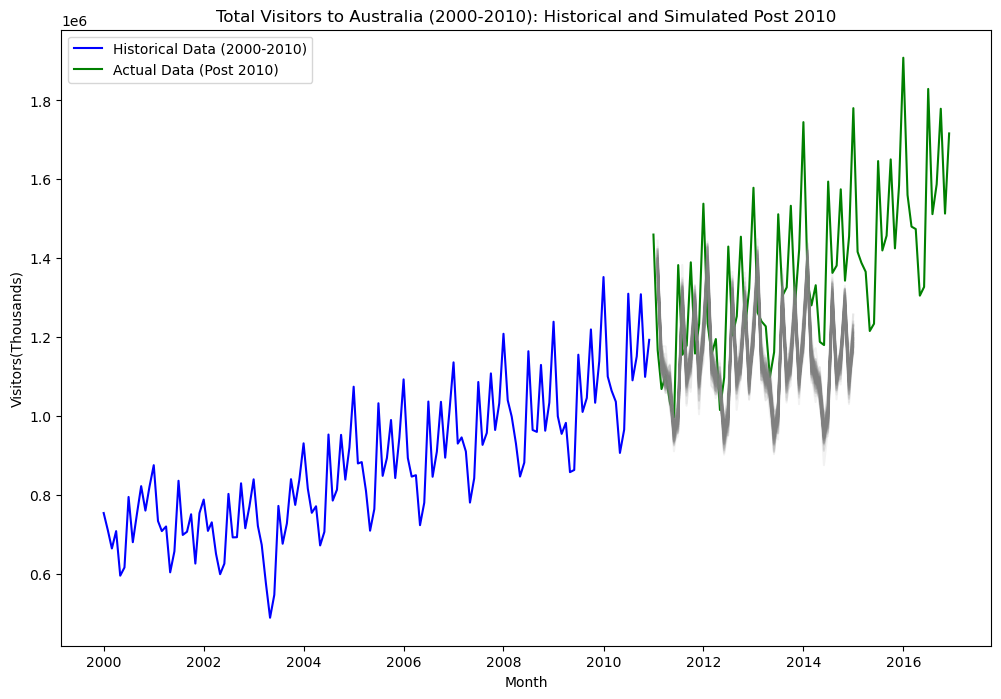

In [6]:
plt.figure(figsize=(12, 8))
austa_filtered = austa[(austa['Month'] >= '2000-01-01') & (austa['Month'] <= '2010-12-31')]
actual_post_2010 = austa[(austa['Month'] > '2010-12-31')& (austa['Month'] <= '2016-12-31')]
sns.lineplot(data=austa_filtered, x='Month', y='Visitors', label='Historical Data (2000-2010)', color='blue')
sns.lineplot(data=actual_post_2010, x='Month', y='Visitors', label='Actual Data (Post 2010)', color='green')

for i in range(1, num_simulations+1):
    sim_data = simulated_paths[simulated_paths['Simulation'] == i]
    sns.lineplot(data=sim_data, x='Month', y='Visitors', color='gray', alpha=0.1)
    
plt.title("Total Visitors to Australia (2000-2010): Historical and Simulated Post 2010")
plt.xlabel("Month")
plt.ylabel("Visitors(Thousands)")
plt.legend()
plt.show()

## 예제 2-3. CRPS 계산 예시

### 필요한 패키지 불러오기

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import nbinom

### 음이항 분포의 밀도 함수 및 누적 함수 생성

In [8]:
r = 10  # 성공 횟수
p = 0.5  # 성공 확률

x = np.arange(0, 50)

pmf = nbinom.pmf(x, r, p)
cdf = nbinom.cdf(x, r, p)

### CRPS 시각화

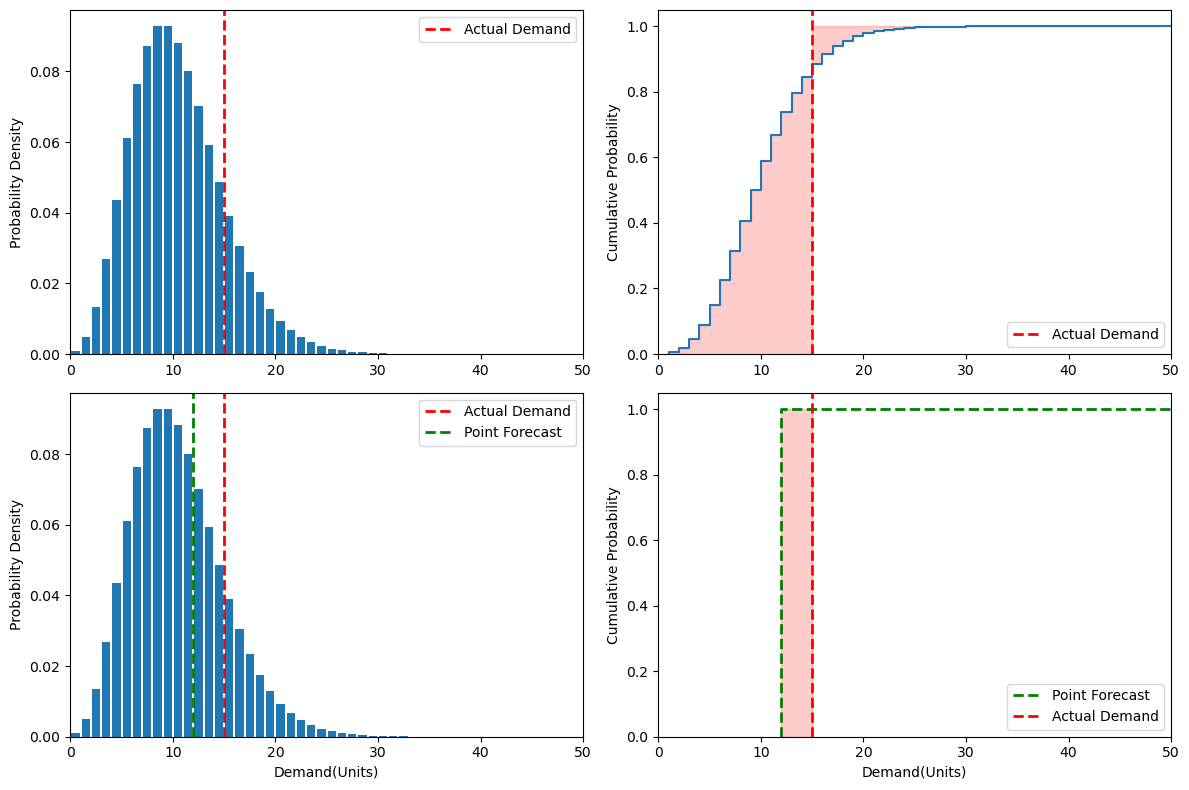

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=False)

axes[0, 0].bar(x+0.5, pmf)
axes[0, 0].axvline(x=15, color="red", linestyle="--", linewidth=2, label="Actual Demand")
axes[0, 0].set_ylabel('Probability Density')
axes[0, 0].legend()
axes[0, 0].set_xlim(0, 50)
axes[0, 0].set_ylim(0)

axes[0, 1].step(x+1, cdf)
axes[0, 1].axvline(x=15, color="red", linestyle="--", linewidth=2, label="Actual Demand")
axes[0, 1].set_ylabel('Cumulative Probability')
axes[0, 1].fill_between(np.arange(1, 16), 0, cdf[:15], step="pre", color='red', alpha=.2)
axes[0, 1].fill_between(np.arange(15, 50), 1, cdf[14:49], step="pre", color='red', alpha=.2)
axes[0, 1].legend()
axes[0, 1].set_xlim(0, 50)
axes[0, 1].set_ylim(0)

axes[1, 0].bar(x+0.5, pmf)
axes[1, 0].axvline(x=15, color="red", linestyle="--", linewidth=2, label="Actual Demand")
axes[1, 0].axvline(x=12, color="green", linestyle="--", linewidth=2, label="Point Forecast")
axes[1, 0].set_ylabel('Probability Density')
axes[1, 0].set_xlabel('Demand(Units)')
axes[1, 0].legend()
axes[1, 0].set_xlim(0, 50)
axes[1, 0].set_ylim(0)

axes[1, 1].step([12,13,50], [0,1,1], linestyle="--", color="green", linewidth=2, label="Point Forecast")
axes[1, 1].axvline(x=15, color="red", linestyle="--", linewidth=2, label="Actual Demand")
axes[1, 1].fill_between(np.arange(12, 16), 0, 1, step="pre", color='red', alpha=.2)
axes[1, 1].set_ylabel('Cumulative Probability')
axes[1, 1].set_xlabel('Demand(Units)')
axes[1, 1].legend()
axes[1, 1].set_xlim(0, 50)
axes[1, 1].set_ylim(0)

plt.tight_layout()
plt.show()

## 예제 2-4.  확률적 예측 예시

### 호주 방문자 수 데이터의 확률적 예측 

### 필요한 패키지 불러오기

In [10]:
import matplotlib.pyplot as plt
import numpy as np

### 데이터 불러오기

In [11]:
austa = pd.read_csv('https://raw.githubusercontent.com/safeai-snu/Econometrics/refs/heads/main/Part.1/data/aus_visit.csv',index_col=0)
austa['Month'] = pd.to_datetime(austa['Month'])

### 학습 데이터 분리

In [12]:
austa_up_to_2010 = austa[austa['Month'] <= '2010-12-31']

### 확률적 예측

In [13]:
austa_up_to_2010.set_index('Month', inplace=True)
rolling_window = 12 
median_forecast = austa_up_to_2010['Visitors'].rolling(window=rolling_window).median()
p90_forecast = austa_up_to_2010['Visitors'].rolling(window=rolling_window).quantile(0.9)
p10_forecast = austa_up_to_2010['Visitors'].rolling(window=rolling_window).quantile(0.1)

### 데이터 시각화

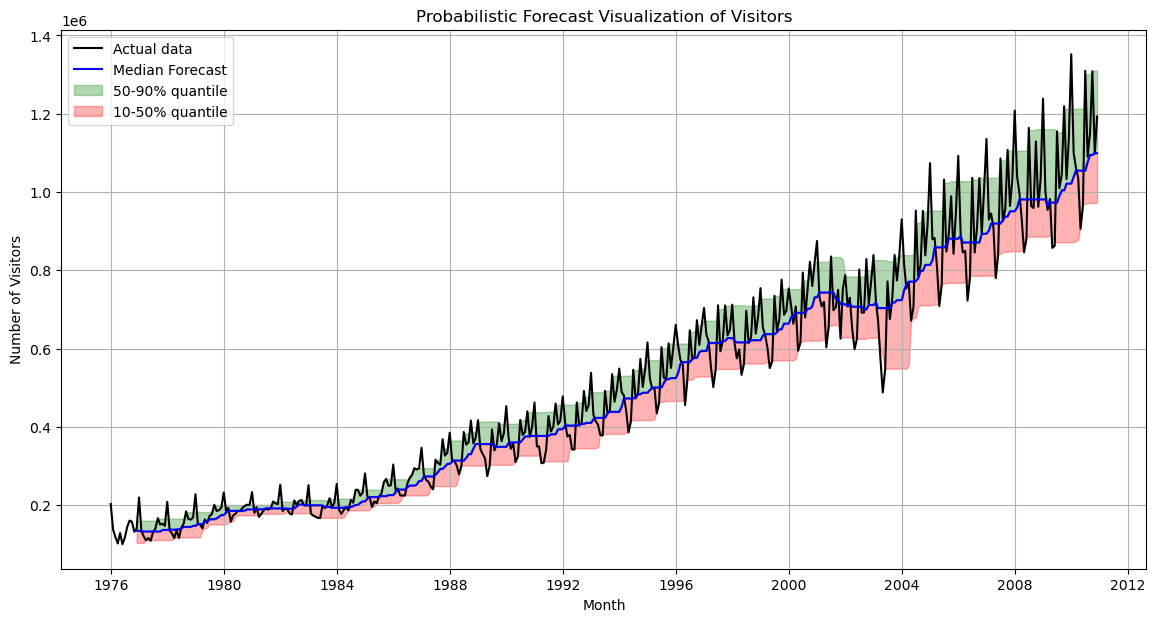

In [14]:
plt.figure(figsize=(14, 7))
plt.plot(austa_up_to_2010.index, austa_up_to_2010['Visitors'], label='Actual data', color='black')
plt.plot(austa_up_to_2010.index, median_forecast, label='Median Forecast', color='blue')
plt.fill_between(austa_up_to_2010.index, median_forecast, p90_forecast, color='green', alpha=0.3, label='50-90% quantile')
plt.fill_between(austa_up_to_2010.index, median_forecast, p10_forecast, color='red', alpha=0.3, label='10-50% quantile')

plt.grid(True)
plt.title('Probabilistic Forecast Visualization of Visitors')
plt.xlabel('Month')
plt.ylabel('Number of Visitors')
plt.legend()
plt.show()